In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np 
import matplotlib.dates as mdates
import os
import datetime
import xarray as xr
import rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math

from functions import *

# Dataset Exploration

Spatial statistics:
- R spatial model of co-regionalization - on different counties - look at if things happen differently between counties

Notes:
- 2 year lag on prescribed acres seems to have highest correlation
- prescribed burns might be more effective in humbolt
- chi squared question (county, years)
- 3 and 6 month prescribed burn increments have significant effect
- 5 km not significant - could be too small of a disance

to do:
- do county chi-squared, add treatment as chi-squared add year
- log linear - poisson regression - probability of fire in year, compare counties offset term - will give a rate of wildfire in each county per km, each row is wildfire
- spatial component - x closest, normalize by size of prescribed and distance

done:
- mixed effect model with county variable
- linear model for wildfires, soil moisture, etc previous month
- treatment analysis with non-parametric test
- initial county data analysis
- built data set for treatment analysis
- log transform
- build county datasets https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/county/time-series

counties:
- sequoia national park -  Tulare County
- Humboldt County 

## Wildfires

In [2]:
df = pd.read_csv("mapdataall.csv")
df["incident_date_created"] = pd.to_datetime(df["incident_date_created"].fillna(df["incident_date_extinguished"]))
df["year"] = df["incident_date_created"].dt.year
df = df.sort_values("incident_date_created", ascending=True)
df = df.loc[df["year"].astype(int)>2015].fillna(0).reset_index(drop=True)

In [3]:
df

,incident_name,incident_is_final,incident_date_last_update,incident_date_created,incident_administrative_unit,incident_administrative_unit_url,incident_county,incident_location,incident_acres_burned,incident_containment,...,incident_type,incident_id,incident_url,incident_date_extinguished,incident_dateonly_extinguished,incident_dateonly_created,is_active,calfire_incident,notification_desired,year
0,Gorman Fire,Y,2016-04-19T15:30:00Z,2016-04-19 13:09:00+00:00,Los Angeles County Fire,0.0,Los Angeles,off northbound Interstate 5 at Gorman Creek,0.0,100.0,...,0,2c77fa07-73e6-45fe-a527-5bd526bdef41,https://osfm.fire.ca.gov/incidents/2016/4/19/g...,2016-04-19T15:30:00Z,2016-04-19,2016-04-19,N,False,False,2016
1,Taglio Fire,Y,2016-04-24T15:30:00Z,2016-04-24 11:10:00+00:00,CAL FIRE Madera-Mariposa-Merced Unit,0.0,Merced,"I-5 & Taglio Road, east of Gustine",30.0,100.0,...,0,7106ba43-100b-41f9-acbf-9fb9e9ab9ef7,https://osfm.fire.ca.gov/incidents/2016/4/24/t...,2016-04-24T15:30:00Z,2016-04-24,2016-04-24,N,True,False,2016
2,Shedd Fire,Y,2016-05-10T18:45:00Z,2016-05-10 16:11:00+00:00,CAL FIRE San Luis Obispo Unit,0.0,San Luis Obispo,Wood Canyon Rd & Hwy 41,150.0,100.0,...,0,1d76ca50-aa10-4f90-bd99-a80bcf2eacce,https://osfm.fire.ca.gov/incidents/2016/5/10/s...,2016-05-10T18:45:00Z,2016-05-10,2016-05-10,N,True,False,2016
3,Bryson Fire,Y,2016-05-12T20:45:00Z,2016-05-12 14:13:00+00:00,CAL FIRE San Benito-Monterey Unit,0.0,Monterey,"Bryson-Hesperia Rd & Interlake Rd, west of Bra...",25.0,100.0,...,0,afaa2efe-d946-4ff9-93c2-459aad31b908,https://osfm.fire.ca.gov/incidents/2016/5/12/b...,2016-05-12T20:45:00Z,2016-05-12,2016-05-12,N,True,False,2016
4,Avocado Fire,Y,2016-05-17T19:10:00Z,2016-05-15 16:38:00+00:00,CAL FIRE Fresno-Kings Unit,0.0,Fresno,"Off Piedra Rd near Kings River, 10 miles north...",132.0,100.0,...,0,f1769b9d-c522-4a0d-92a7-f9c8321b9f1d,https://osfm.fire.ca.gov/incidents/2016/5/15/a...,2016-05-17T19:10:00Z,2016-05-17,2016-05-15,N,True,False,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846,Coyote Fire,Y,2023-08-20T19:14:48Z,2023-08-17 12:11:00+00:00,Unified Command: CAL FIRE San Diego Unit and S...,0.0,San Diego,Coyote Holler Road and Round Potrero Road,466.0,100.0,...,Wildfire,243c4ae4-f7eb-44f4-b5e8-ff8c4baaccd5,https://osfm.fire.ca.gov/incidents/2023/8/17/c...,0,0,2023-08-17,N,True,False,2023
1847,Thirty Five Fire,Y,2023-08-17T18:19:56Z,2023-08-17 12:36:00+00:00,CAL FIRE Tehama-Glenn Unit,0.0,Glenn,"County Road 35 and County Road 33, west of Artois",109.0,100.0,...,Wildfire,1c3481f5-3d33-40a2-8f24-5edbebc17d6c,https://osfm.fire.ca.gov/incidents/2023/8/17/t...,2023-08-17T17:00:00Z,2023-08-17,2023-08-17,N,True,False,2023
1848,Plant Fire,Y,2023-09-01T08:56:08Z,2023-08-19 13:25:33+00:00,Los Padres National Forest Service,0.0,Santa Barbara,"Aliso Park Road and Foothill Road, New Cuyama",0.0,100.0,...,Wildfire,e3297f9e-f753-49b6-9cdf-78700edde34f,https://osfm.fire.ca.gov/incidents/2023/8/19/p...,2023-08-31T15:00:00Z,2023-08-31,2023-08-19,N,False,False,2023
1849,SRF Lightning Complex,N,2023-09-01T19:16:17Z,2023-08-20 11:16:48+00:00,Six Rivers National Forest,0.0,Humboldt,Humboldt County,0.0,0.0,...,Wildfire,ad8025a3-0060-49db-a048-bce567ee0a57,https://osfm.fire.ca.gov/incidents/2023/8/20/s...,0,0,2023-08-20,Y,False,False,2023


In [4]:
df.describe().round(3)

,incident_administrative_unit_url,incident_acres_burned,incident_containment,incident_longitude,incident_latitude,year
count,1851.0,1851.000,1851.000,1.851000e+03,1851.000,1851.000
mean,0.0,5023.281,97.207,-6.437798e+05,40.075,2018.935
std,0.0,40960.796,16.412,2.769234e+07,126.831,2.007
min,0.0,0.000,0.000,-1.191415e+09,-120.258,2016.000
25%,0.0,32.000,100.000,-1.218020e+02,34.849,2017.000
50%,0.0,89.000,100.000,-1.206420e+02,37.369,2019.000
75%,0.0,356.000,100.000,-1.187010e+02,39.295,2020.000
max,0.0,1032648.000,100.000,1.189080e+02,5487.000,2023.000


In [5]:
df[['incident_county', 'incident_type', 'incident_administrative_unit']].describe()

,incident_county,incident_type,incident_administrative_unit
count,1851,1851,1851
unique,91,4,630
top,Riverside,0,CAL FIRE Santa Clara Unit
freq,186,919,72


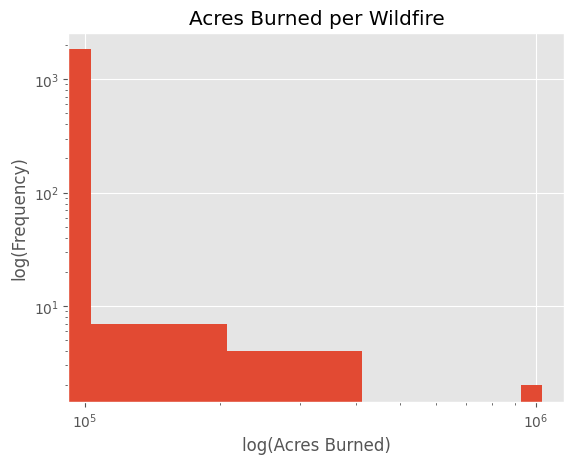

In [11]:
plt.figure()
hist, bins, _ = plt.hist(df["incident_acres_burned"].tolist(), log=True)
plt.xscale('log')
plt.title("Acres Burned per Wildfire")
plt.xlabel("log(Acres Burned)")
plt.ylabel("log(Frequency)")
plt.show()

In [7]:
fig = px.scatter_geo(df, lat="incident_latitude", lon="incident_longitude", scope='usa', animation_frame="year", size="incident_acres_burned")
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## Prescribed Fires

In [ ]:
import geopandas as gpd
gdf = gpd.read_file("California_Fire_Perimeters_(all).geojson")

In [ ]:
gdf["START_DATE"] = pd.to_datetime(gdf["START_DATE"], errors = 'coerce')

In [ ]:
gdf["START_DATE"] = gdf["START_DATE"].fillna(pd.to_datetime(gdf["END_DATE"],  errors = 'coerce'))

In [ ]:
gdf = gdf.dropna(subset=["START_DATE"])

In [ ]:
gdf = gdf.sort_values('START_DATE', ascending=True)

In [ ]:
gdf["year"] = gdf["START_DATE"].dt.year

In [ ]:
gdf["lon_center"] = gdf["geometry"].centroid.x
gdf["lat_center"] = gdf["geometry"].centroid.y
gdf["YEAR_"] = gdf["YEAR_"].astype(int)
gdf = gdf.fillna(0)

C:\Users\sequo\AppData\Local\Temp\ipykernel_18612\344453164.py:1: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\sequo\AppData\Local\Temp\ipykernel_18612\344453164.py:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [ ]:
gdf = gdf.reset_index(drop=True)

In [ ]:
gdf["acres_decimal"] = [convert_acres_degrees(gdf.at[i,"TREATED_AC"], gdf.at[i, "lat_center"]) for i in range(len(gdf))]
df["acres_decimal"] = [convert_acres_degrees(df.at[i,"incident_acres_burned"], df.at[i, "incident_latitude"]) for i in range(len(df))]

In [ ]:
gdf = gdf.set_index("START_DATE")
gdf = gdf.loc['2016-01-01':'2022-12-31']

In [ ]:
gdf

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,TREATMENT_ID,TREATMENT_NAME,TREATMENT_TYPE,END_DATE,TREATED_AC,...,RX_CONSUM,PRE_CON_CLASS,POST_CON_CLASS,SHAPE_Length,SHAPE_Area,geometry,year,lon_center,lat_center,acres_decimal
START_DATE,,,,,,,,,,,,,,,,,,,,,
2016-02-01 00:00:00+00:00,13498,2021,CA,USF,PNF,2130014000,KEDDIE RIDGE UNIT 18,1.0,2021-09-01T00:00:00+00:00,24.400000,...,0.0,0.0,0.0,0.016012,0.000010,"MULTIPOLYGON (((-120.88560 40.19067, -120.8852...",2016,-120.888104,40.190192,0.002085
2016-02-01 00:00:00+00:00,13221,2021,CA,USF,PNF,2130018000,KEDDIE RIDGE UNIT 30,1.0,2021-09-01T00:00:00+00:00,9.700000,...,0.0,0.0,0.0,0.011291,0.000004,"MULTIPOLYGON (((-120.88078 40.17912, -120.8808...",2016,-120.882498,40.179623,0.001314
2016-02-02 00:00:00+00:00,11750,2016,CA,BLM,CDD,NFPORS6303134,BEAR MEADOW RX FY16,1.0,2016-04-28T00:00:00+00:00,112.000000,...,0.0,0.0,0.0,0.170037,0.000134,"MULTIPOLYGON (((-122.38441 38.96982, -122.3841...",2016,-122.374545,38.985116,0.004389
2016-02-23 00:00:00+00:00,11723,2016,CA,CDF,MVU,004574,CORTE MADERA #2 VMP,1.0,2016-05-13T00:00:00+00:00,50.000000,...,0.0,0.0,0.0,0.017270,0.000019,"MULTIPOLYGON (((-116.55394 32.76843, -116.5537...",2016,-116.552366,32.766214,0.002711
2016-02-23 00:00:00+00:00,11724,2016,CA,CDF,MVU,004574,CORTE MADERA #1 VMP,1.0,2016-05-13T00:00:00+00:00,35.000000,...,0.0,0.0,0.0,0.014754,0.000014,"MULTIPOLYGON (((-116.55942 32.76181, -116.5591...",2016,-116.558350,32.759814,0.002268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-13 00:00:00+00:00,15383,2022,CA,USF,LNF,F343000012,PANTHER HAND THIN & PILE,5.0,2022-12-13T00:00:00+00:00,8.000000,...,0.0,0.0,0.0,0.009196,0.000003,"MULTIPOLYGON (((-121.78002 40.23180, -121.7800...",2022,-121.779521,40.230558,0.001194
2022-12-15 00:00:00+00:00,15726,2022,CA,CSP,749,021,Broadcast Burn,1.0,0,4.925455,...,4.0,0.0,0.0,0.007447,0.000002,"MULTIPOLYGON (((-120.95563 35.45405, -120.9556...",2022,-120.956595,35.454953,0.000878
2022-12-22 00:00:00+00:00,15616,2022,CA,CDF,LNU,14511,2022 Burning,1.0,2022-12-22T00:00:00+00:00,14.600000,...,0.0,0.0,0.0,0.018040,0.000006,"MULTIPOLYGON (((-122.91758 38.44975, -122.9169...",2022,-122.915976,38.449381,0.001573


In [ ]:
gdf[["TREATMENT_TYPE", "TREATED_AC", "GIS_ACRES", "RX_CONSUM", "PRE_CON_CLASS", "POST_CON_CLASS"]].describe().round(3)

,TREATMENT_TYPE,TREATED_AC,GIS_ACRES,RX_CONSUM,PRE_CON_CLASS,POST_CON_CLASS
count,3717.00,3717.000,3717.000,3717.000,3717.000,3717.000
mean,3.30,95.437,136.166,0.042,0.003,0.002
std,1.92,357.633,588.630,0.354,0.082,0.052
min,0.00,0.000,1.001,0.000,0.000,0.000
25%,1.00,3.000,12.119,0.000,0.000,0.000
50%,5.00,20.000,33.778,0.000,0.000,0.000
75%,5.00,72.000,98.397,0.000,0.000,0.000
max,5.00,7006.000,21018.383,4.000,2.000,2.000


In [ ]:
gdf[["year", "AGENCY", "UNIT_ID"]].describe().round(3)

,year
count,3717.000
mean,2019.574
std,1.426
min,2016.000
25%,2019.000
50%,2019.000
75%,2021.000
max,2022.000


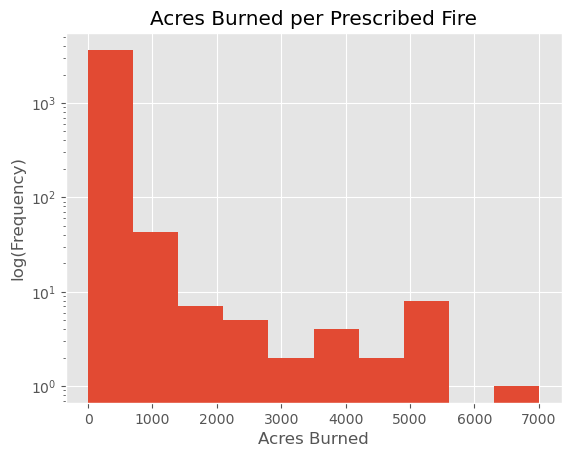

In [ ]:
plt.figure()
hist, bins, _ = plt.hist(gdf["TREATED_AC"].tolist(), log=True)
plt.title("Acres Burned per Prescribed Fire")
plt.xlabel("Acres Burned")
plt.ylabel("log(Frequency)")
plt.show()

In [ ]:
fig = px.scatter_geo(gdf, lat="lat_center", lon="lon_center", scope='usa', animation_frame="year", size="TREATED_AC")
fig.show()

# Prescribed vs Wildland

c:\Users\sequo\AppData\Local\R-MINI~1\envs\thesis\lib\site-packages\matplotlib\collections.py:963: RuntimeWarning:

invalid value encountered in sqrt



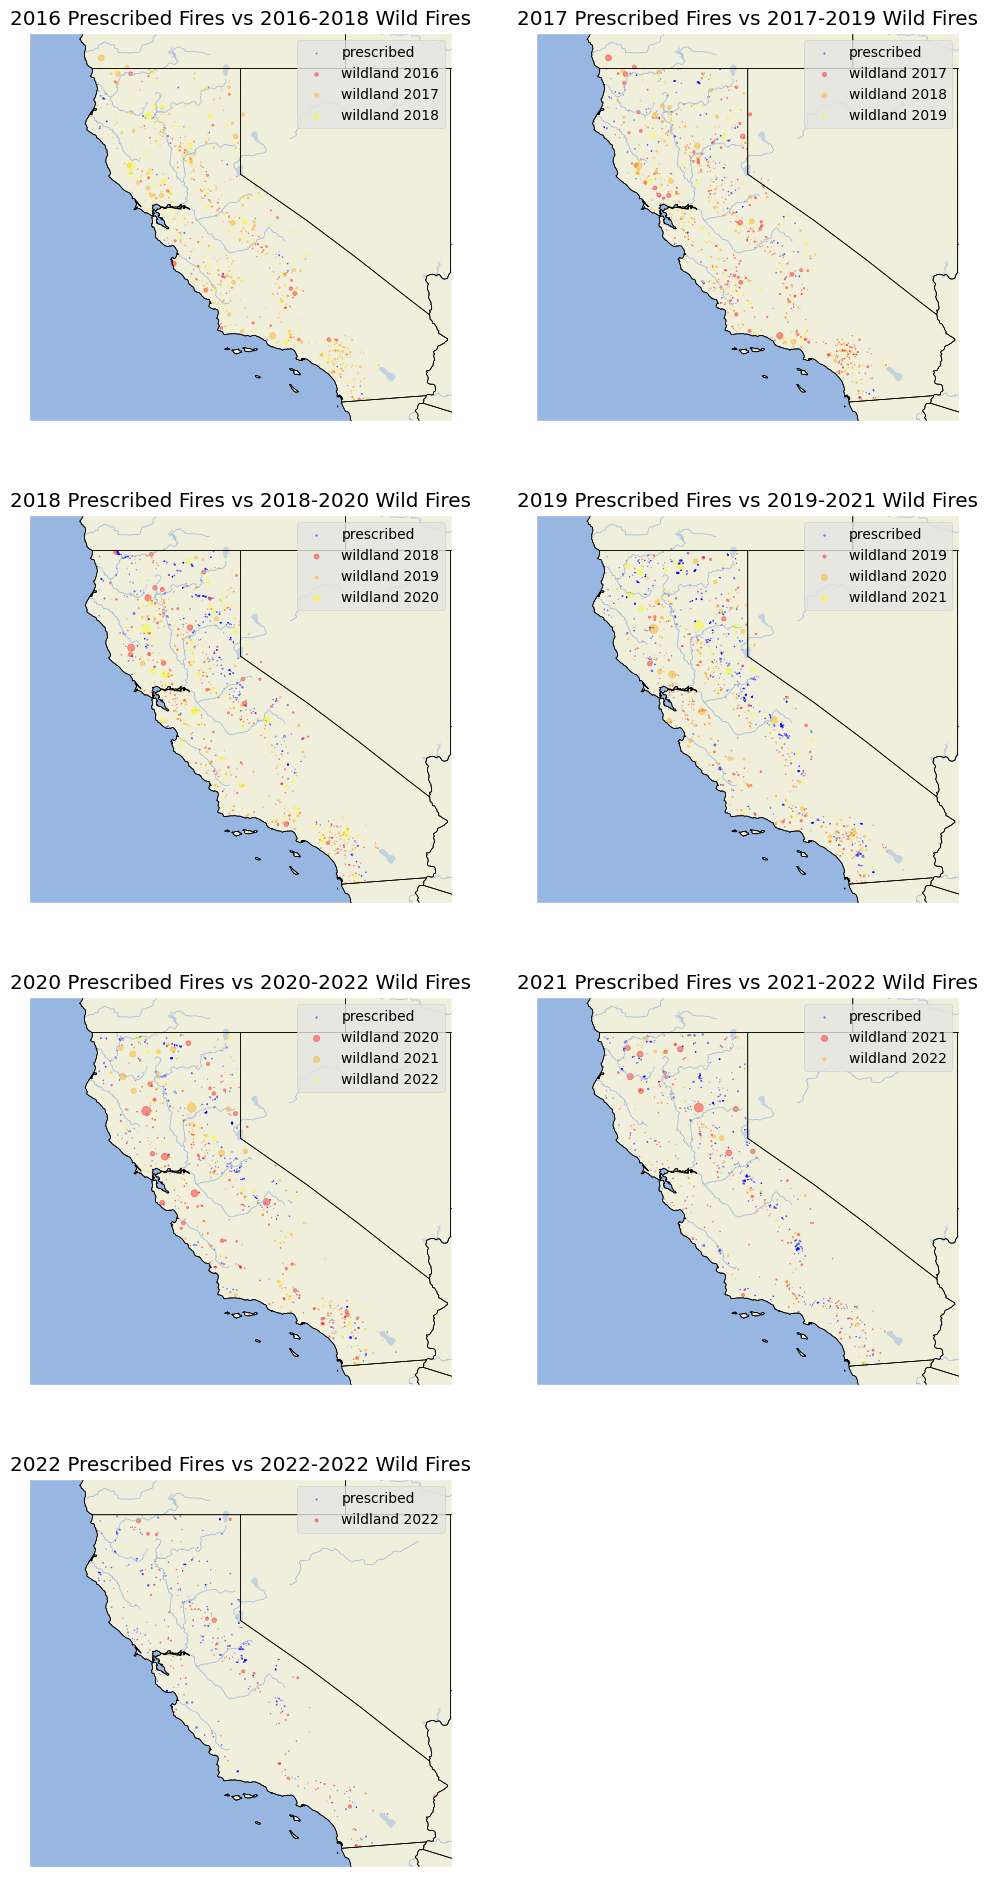

In [ ]:
_ = plot_rx_wild_fires_multi_year(prescribed=gdf, wild=df, years=[2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [ ]:
#_ = plot_rx_wild_fires_singles(prescribed=gdf, wild=df, years=[2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [ ]:
#_ = plot_rx_wild_fires(prescribed=gdf, wild=df, prescribed_year=2016, wild_years=[2016, 2017, 2018, 2019])

In [ ]:
#_ = plot_rx_wild_fires(prescribed=gdf, wild=df, prescribed_year=2017, wild_years=[2017, 2018, 2019, 2020])

In [ ]:
#_ = plot_rx_wild_fires(prescribed=gdf, wild=df, prescribed_year=2018, wild_years=[2018, 2019, 2020, 2021])

In [ ]:
#_ = plot_rx_wild_fires(prescribed=gdf, wild=df, prescribed_year=2019, wild_years=[2019, 2020, 2021, 2022])

In [ ]:
#_ = plot_rx_wild_fires(prescribed=gdf, wild=df, prescribed_year=2020, wild_years=[2020, 2021, 2022])

In [ ]:
#_ = plot_rx_wild_fires(prescribed=gdf, wild=df, prescribed_year=2021, wild_years=[2021, 2022])

In [ ]:
#_ = plot_rx_wild_fires(prescribed=gdf, wild=df, prescribed_year=2022, wild_years=[2022])

## Climate

## Combined Dataset

In [ ]:
data = pd.read_csv("wildfire_data.csv", index_col=0)
data.index = pd.to_datetime(data.index)

## Scatterplots

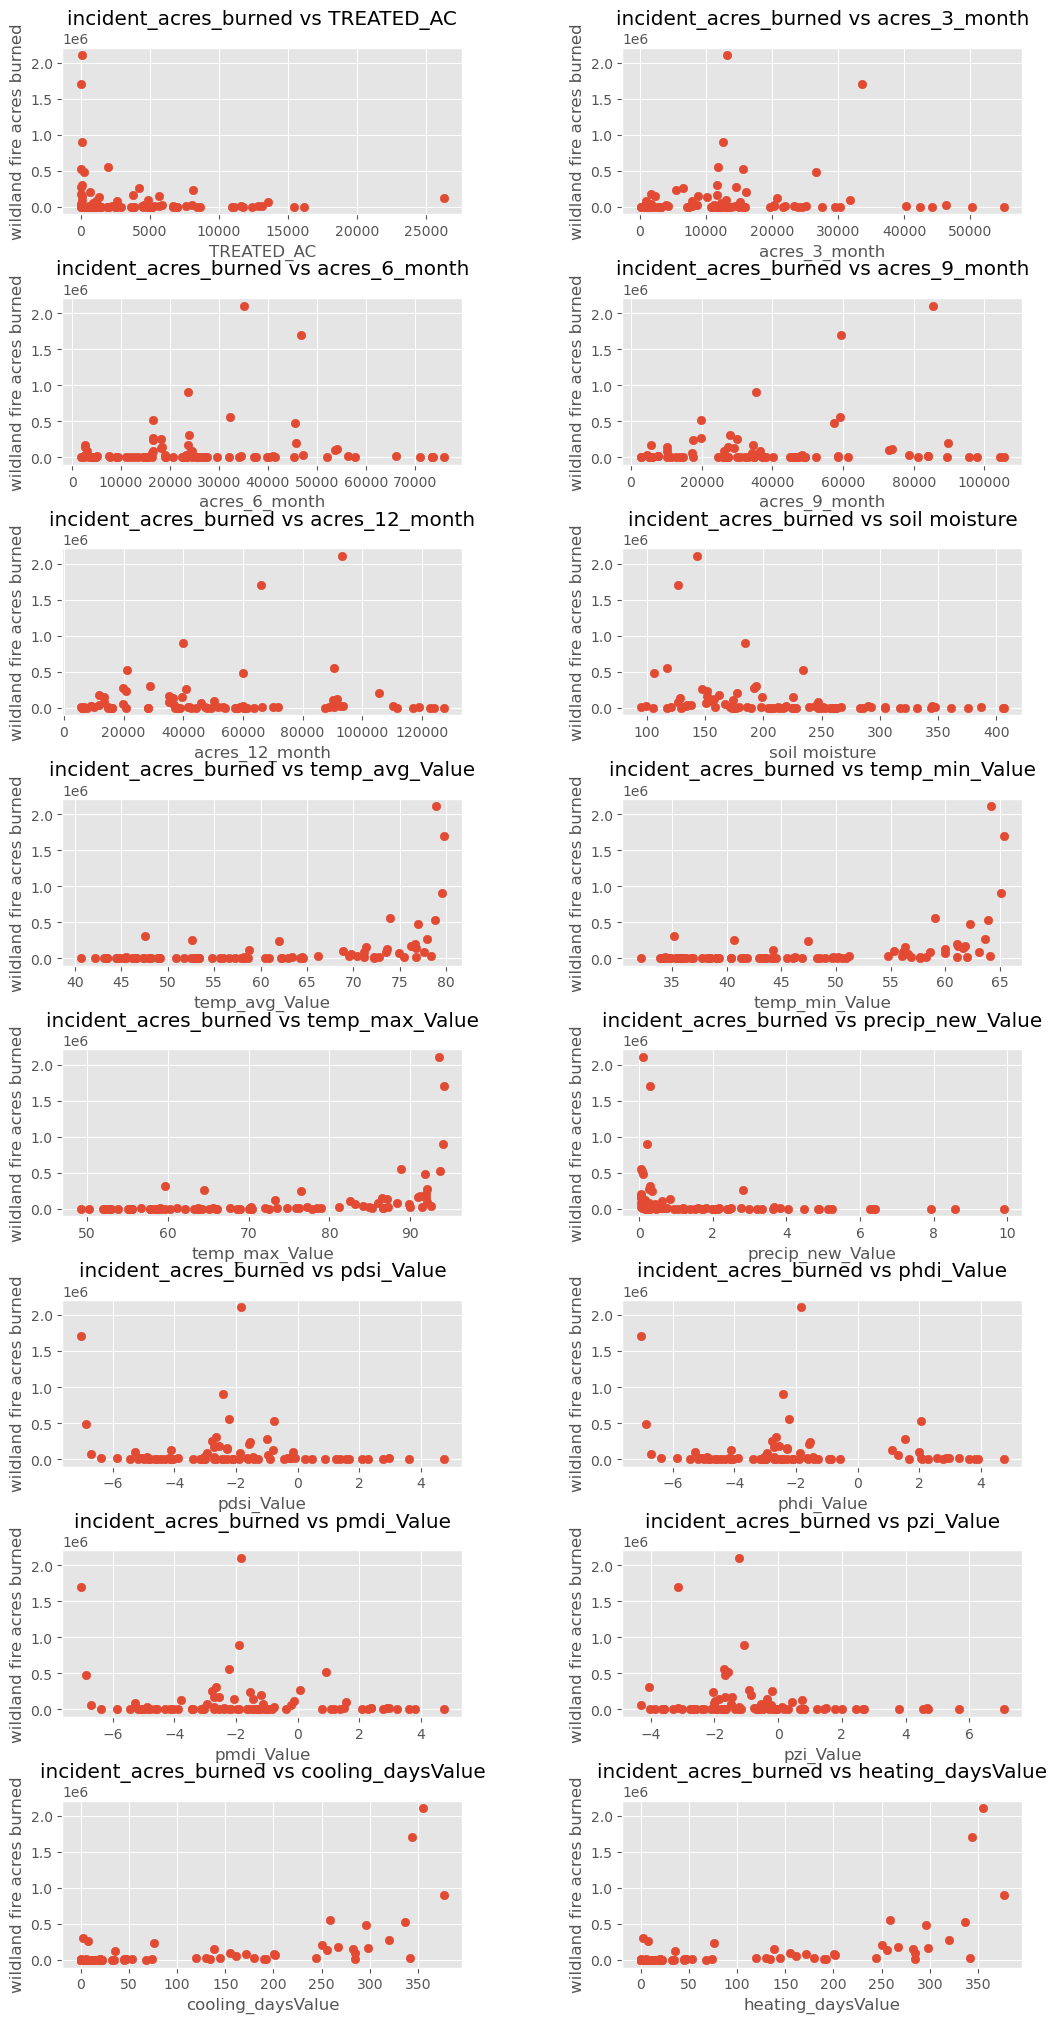

In [ ]:
predictors = [ 'TREATED_AC', 'acres_3_month', 'acres_6_month','acres_9_month', 'acres_12_month', 'soil moisture', 'temp_avg_Value',
              'temp_min_Value', 'temp_max_Value', 'precip_new_Value', 'pdsi_Value', 'phdi_Value', 'pmdi_Value',  'pzi_Value', 
              'cooling_daysValue', 'heating_daysValue']
target = 'incident_acres_burned'
_ = scatter_plots(data, target, predictors)

## Statistics

### Wildland vs Prescribed

mwu / wilcoxson rank-signed

In [ ]:
data["prescribed_10000"] = data['TREATED_AC']>10000
data["prescribed_8000"] = data['TREATED_AC']>8000
data["prescribed_5000"] = data['TREATED_AC']>5000

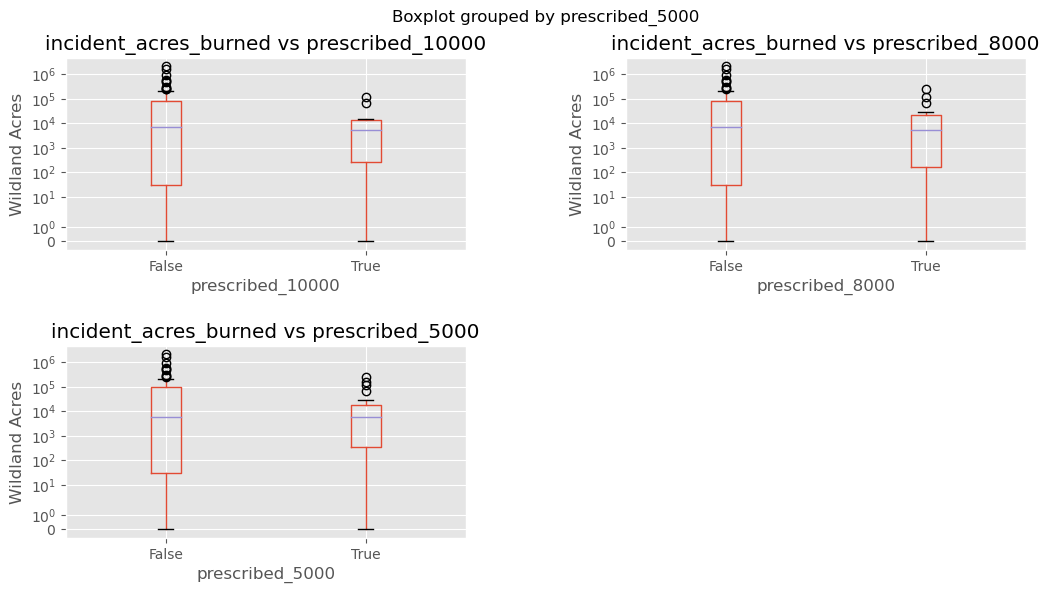

In [ ]:
_ = build_boxplots(data, target, predictors = ["prescribed_10000","prescribed_8000", "prescribed_5000" ])

In [ ]:
mwu, t = run_stats(data, "incident_acres_burned", ["prescribed_5000", "prescribed_8000", "prescribed_10000"])
display(mwu)

,,U-val,alternative,p-val,RBC,CLES
prescribed_5000,MWU,689.0,two-sided,0.530871,0.086207,0.456897
prescribed_8000,MWU,471.0,two-sided,0.589558,0.089855,0.455072
prescribed_10000,MWU,359.0,two-sided,0.576017,0.105853,0.447073


### Wildland vs Drought index

In [ ]:
data["pdsi_0"] = data['pdsi_Value']<0
data["pdsi_-2"] = data['pdsi_Value']<-2

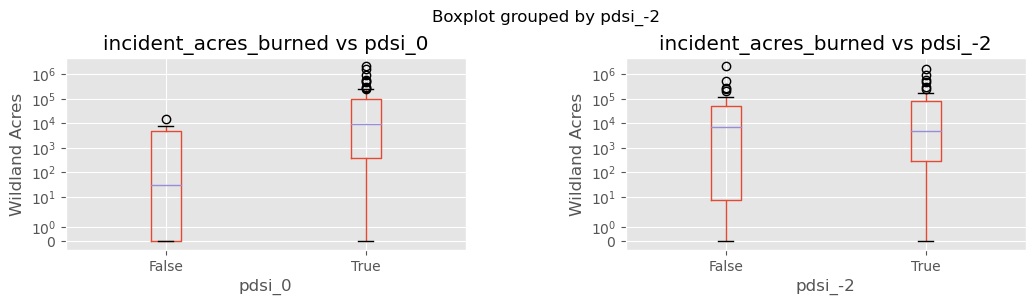

In [ ]:
_ = build_boxplots(data, target, predictors = ["pdsi_0","pdsi_-2"])

In [ ]:
mwu, t = run_stats(data, "incident_acres_burned", ["pdsi_0", "pdsi_-2"])
display(mwu)
display(t)

,,U-val,alternative,p-val,RBC,CLES
pdsi_0,MWU,698.5,two-sided,0.003313,-0.513543,0.756771
pdsi_-2,MWU,862.5,two-sided,0.912560,-0.014706,0.507353


,,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
pdsi_0,T-test,3.112098,70.134618,two-sided,0.002687,"[45632.23, 208476.06]",0.399931,13.864,0.258459
pdsi_-2,T-test,-0.078562,58.690842,two-sided,0.937649,"[-155856.48, 144081.81]",0.018337,0.232,0.050762


# Log-scale target

In [ ]:
data["log_acres"] = np.log(data['incident_acres_burned'].replace(0, np.nan)).replace(np.nan, 0)

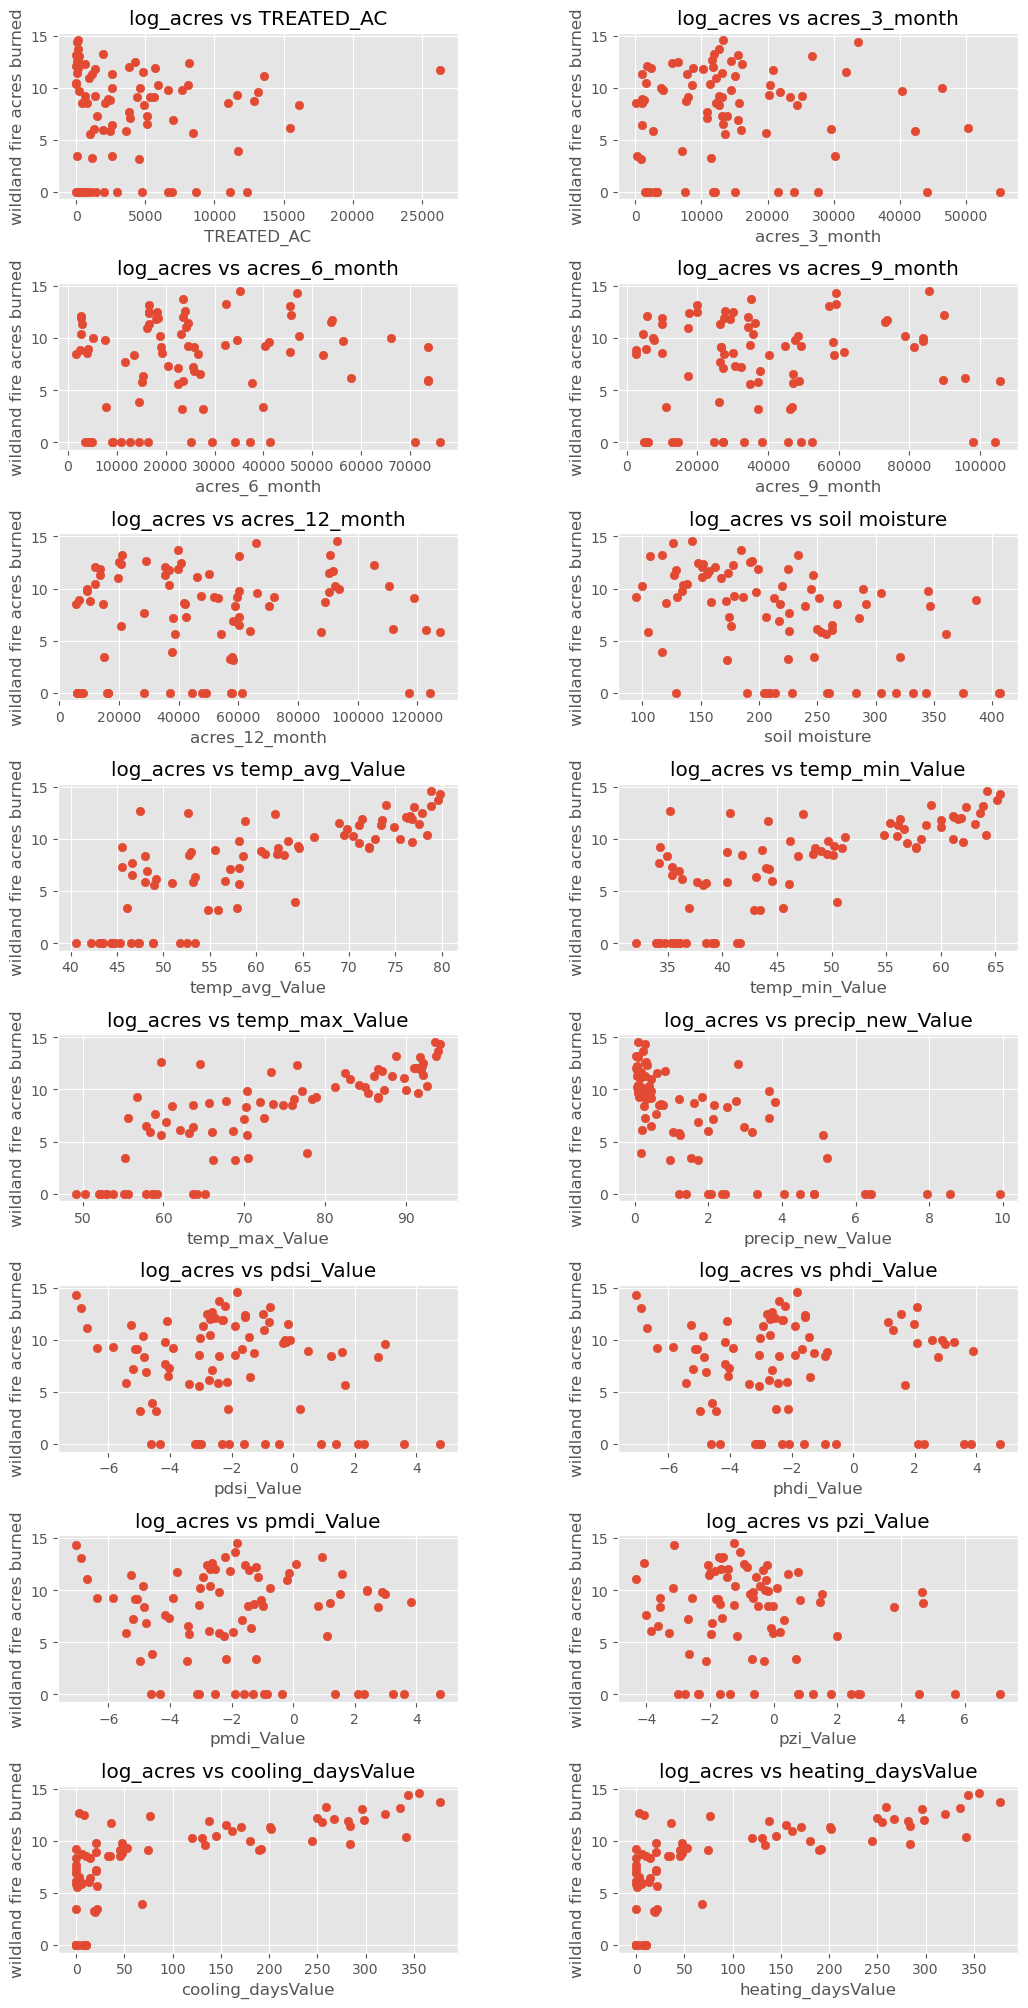

In [ ]:
predictors = [ 'TREATED_AC', 'acres_3_month', 'acres_6_month','acres_9_month', 'acres_12_month', 'soil moisture', 'temp_avg_Value',
              'temp_min_Value', 'temp_max_Value', 'precip_new_Value', 'pdsi_Value', 'phdi_Value', 'pmdi_Value',  'pzi_Value', 
              'cooling_daysValue', 'heating_daysValue']
target = 'log_acres'
_ = scatter_plots(data, target, predictors)

In [ ]:
mwu, t = run_stats(data, "log_acres", ["prescribed_5000", "prescribed_8000", "prescribed_10000"])
display(mwu)

,,U-val,alternative,p-val,RBC,CLES
prescribed_5000,MWU,689.0,two-sided,0.530871,0.086207,0.456897
prescribed_8000,MWU,471.0,two-sided,0.589558,0.089855,0.455072
prescribed_10000,MWU,359.0,two-sided,0.576017,0.105853,0.447073


In [ ]:
mwu, t = run_stats(data, "log_acres", ["pdsi_0", "pdsi_-2"])
display(mwu)

,,U-val,alternative,p-val,RBC,CLES
pdsi_0,MWU,698.5,two-sided,0.003313,-0.513543,0.756771
pdsi_-2,MWU,862.5,two-sided,0.912560,-0.014706,0.507353


# Chi-squared